# STIF example

In this example notebook, we will analyze the spatio-temporal distribution of particulate matter (PM10) in Germany during the year 2005. In addition, we will interpolate between measurements and extrapolate into the future using spacetime regression Kriging.

First, we install the package, including the `geo` extras, which are necessary for geodata I/O and map projections.

In [1]:
%pip install stif[geo]

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import sklearn.metrics

from stif import Data
from stif import Predictor

First, we load the sample data. Time is is days, x and y are in meters.

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/johanneskopton/stif/main/tests/data/pm10.csv", index_col=0)
df = df[["x", "y", "time", "PM10"]]

In [4]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y']))

gdf["time"] -= gdf["time"].min()
gdf["date"] = pd.to_datetime(gdf["time"], unit='D', origin='2015-01-01')

# Set the CRS for UTM zone 32N (EPSG:32632)
gdf.set_crs(epsg=32632, inplace=True)

gdf

,x,y,time,PM10,geometry,date
1,538708.582738,5.947030e+06,0,16.696,POINT (538708.583 5947029.695),2015-01-01
2,545413.585073,5.930802e+06,0,31.667,POINT (545413.585 5930802.118),2015-01-01
3,665710.585392,5.315213e+06,0,5.000,POINT (665710.585 5315212.698),2015-01-01
4,551796.486023,5.991947e+06,0,22.450,POINT (551796.486 5991946.712),2015-01-01
5,815738.296939,5.821001e+06,0,26.750,POINT (815738.297 5821000.937),2015-01-01
...,...,...,...,...,...,...
25179,554010.659907,5.682555e+06,364,6.250,POINT (554010.660 5682555.084),2015-12-31
25180,611289.733291,5.735371e+06,364,2.583,POINT (611289.733 5735370.738),2015-12-31
25181,647144.649255,5.829232e+06,364,14.333,POINT (647144.649 5829231.749),2015-12-31
25182,741354.165710,6.038523e+06,364,18.750,POINT (741354.166 6038523.370),2015-12-31


Let's add some elevation as additional covariable.

In [5]:
# Read the GeoTIFF file
tiff_path = 'https://github.com/johanneskopton/stif/raw/main/tests/data/elevationeurope1x1.tif'

with rasterio.open(tiff_path) as src:
    raster_crs = src.crs

    # Reproject the GeoDataFrame to match the raster's CRS
    gdf = gdf.to_crs(raster_crs)

    # Extract elevation values
    def get_elevation(x, y):
        row, col = src.index(x, y)
        return src.read(1)[row, col]

    # Apply the function to extract elevation data
    gdf['elevation'] = gdf.apply(lambda row: get_elevation(
        row.geometry.x, row.geometry.y), axis=1)

Change coordinate system of the geometry column to better vizualize the measurement locations with their respective elevations.

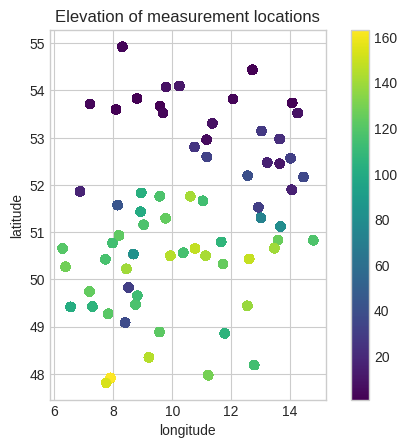

In [6]:
gdf = gdf.to_crs(epsg=4326)
fig, ax = plt.subplots()
gdf.plot(column="elevation", cmap="viridis", legend=True, ax=ax)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_title("Elevation of measurement locations")
pass

Then we create a `stif.Data` object for preprocessing: 

In [7]:
data = Data(
    gdf,
    space_cols=["x", "y"],
    time_col="time",
    predictand_col="PM10",
    covariate_cols=["elevation"],
)

To handle external drift (linear relationship to elevation), we perform a linear regression and do the geostatistics only on the residuals of this regression ("regression Kriging"). If we had more external covariates, i.e. other variables also for locations / time points where we don't have PM10 data, we could also use these here.

The regression can be arbitrarily complex (e.g. Neural Network or Random Forest regression), but we stay with a simple linear regression for now. But keep in mind that any sklearn or Keras model, can be plugged in here.

In [8]:
covariate_model = LinearRegression()
predictor = Predictor(data, covariate_model)

To evaluate the covariate model, we perform a time series cross validation and plot the results.

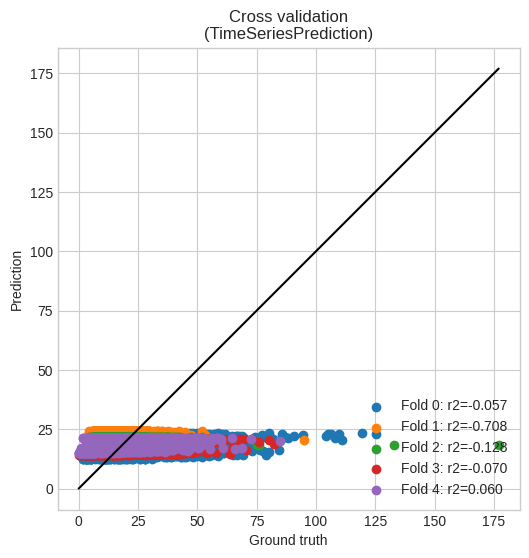

Explained variance:  [0.028263224509155305, -0.03837089919760839, 0.030910240067397954, 0.028618197550811852, 0.13407934054716675]


In [9]:
predictor.calc_cross_validation()
predictor.plot_cross_validation_residuals()
score = predictor.get_cross_val_metric(
    sklearn.metrics.explained_variance_score,
)
print("Explained variance: ", score)

Not surprisingly, the prediction only based on a linear relationship to elevation is terrible (slightly better than nothing though). To demonstrate the procedure, we continue working with the residuals of this regression. 

Now, we can calculate an empirical variogram to analyze the spatio-temporal distribution and use it for space-time Kriging later.

In [10]:
variogram_params = {
    "space_dist_max": 6e5,
    "time_dist_max": 10,
    "el_max": 1e8
}

predictor.calc_empirical_variogram(**variogram_params)

Let's have a look at the space-time varigoram.

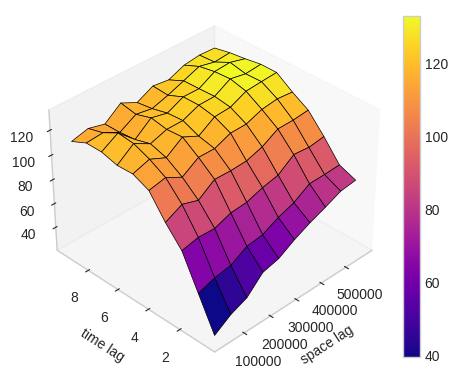

In [11]:
predictor.plot_empirical_variogram()

As we can see, there is significant autocorrelation, especially for time lags less than 5 days and space lags less than a couple of hundred kilometers.

Now lets fit a model to the empirical variogram:

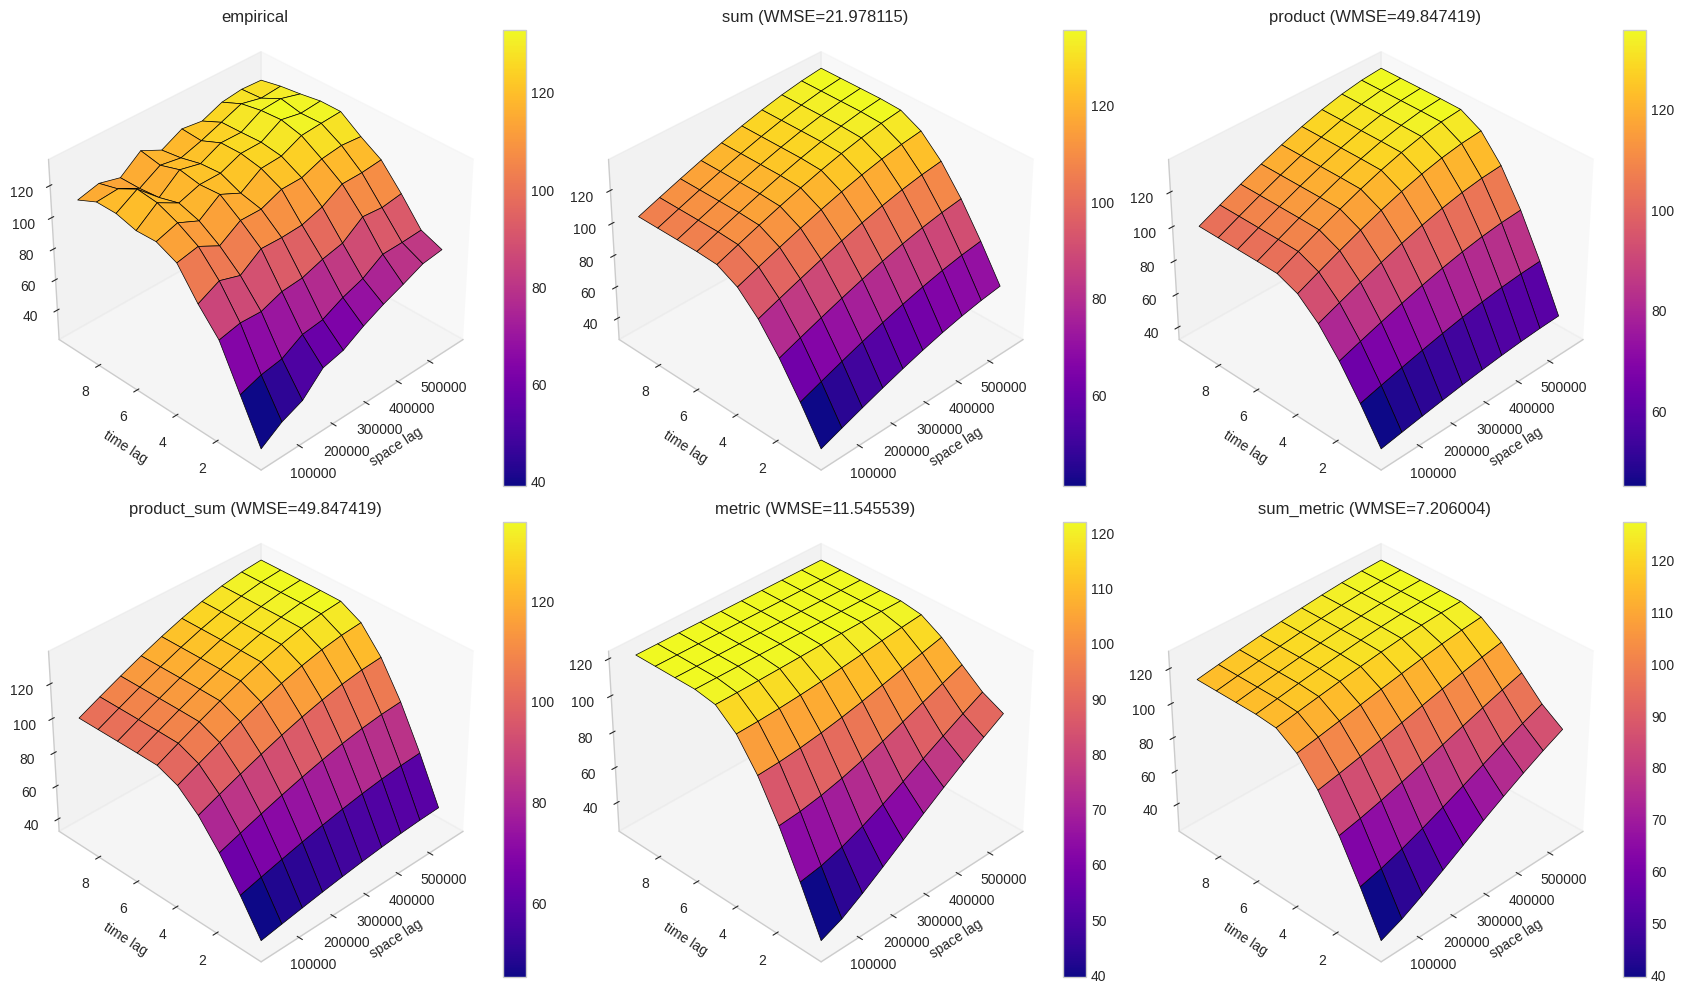

In [12]:
predictor.plot_variogram_model_comparison()

As we can see, the `sum_metric` model performs best. Let's see, how Kriging performs using this variogram model. To evaluate that, we again use timeseries cross-validation to predict into the future, but this time we do not only the covariate regression, but also Kriging:

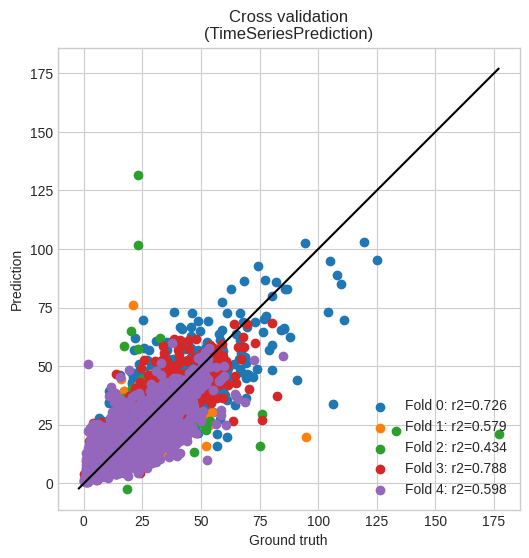

In [13]:
kriging_params = {
    "min_kriging_points": 1,
    "max_kriging_points": 10,
    "space_dist_max": 2e5,
}

predictor.calc_cross_validation(
    kriging=True,
    geostat_params={
        "variogram_params": variogram_params,
        "kriging_params": kriging_params,
    },
)
predictor.plot_cross_validation_residuals()

So this doesn't look too bad! Keep in mind, that we are only using observations from the past to infer to our new locations. The mean absolute error also looks decent:

In [14]:
predictor.get_cross_val_metric(
    sklearn.metrics.mean_absolute_error)

[4.710507798878166,
 2.7830046348491244,
 3.066644436096627,
 3.837238469322995,
 4.396366326037173]

Finally let's predict the PM10 values for a grid over Germany, on one particular exemplary day. First, calculate the empirical variogram and fit the variogram model using all available training data:

In [15]:
predictor.calc_empirical_variogram(**variogram_params)
predictor.fit_variogram_model(st_model='sum_metric')

Now we create a grid, covering all of Germany.

In [16]:
lat_min, lat_max = df.y.min(), df.y.max()
lon_min, lon_max = df.x.min(), df.x.max()
lat_step = 10000 # in m
lon_step = 10000 # in m


latitudes = np.arange(lat_min, lat_max + lat_step, lat_step)
longitudes = np.arange(lon_min, lon_max + lon_step, lon_step)
lat_grid, lon_grid = np.meshgrid(latitudes, longitudes)

Next, we create a GeoDataFrame from this grid and use an arbitrary date (1st of March) for this example.

In [17]:
start_date = pd.to_datetime('2015-01-01')
target_date = pd.to_datetime('2015-03-01')

# Calculate the difference in days
date_int = (target_date - start_date).days

prediction_df = pd.DataFrame(
    {"x": lon_grid.flatten(), "y": lat_grid.flatten(), "time": date_int})


prediction_gdf = gpd.GeoDataFrame(
    prediction_df,
    geometry=gpd.points_from_xy(prediction_df['x'], prediction_df['y'])
)

# Set the CRS for UTM zone 32N (EPSG:32632)
prediction_gdf.set_crs(epsg=32632, inplace=True)
pass

As we did with our training data, we add the elevation covariable to the prediction grid.

In [18]:
with rasterio.open(tiff_path) as src:
    raster_crs = src.crs

    # Reproject the GeoDataFrame to match the raster's CRS
    prediction_gdf = prediction_gdf.to_crs(raster_crs)

    # Extract elevation values
    def get_elevation(x, y):
        row, col = src.index(x, y)
        return src.read(1)[row, col]

    # Apply the function to extract elevation data
    prediction_gdf['elevation'] = prediction_gdf.apply(lambda row: get_elevation(
        row.geometry.x, row.geometry.y), axis=1)

Let's have a look at our prediction locations and their elevation:

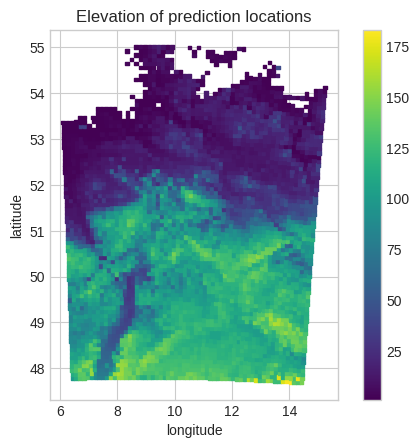

In [19]:
prediction_gdf = prediction_gdf.to_crs(epsg=4326)
prediction_gdf = prediction_gdf.loc[prediction_gdf.elevation > 0]
fig, ax = plt.subplots()
prediction_gdf.plot(column="elevation", cmap="viridis", legend=True, ax=ax, markersize=6, marker="s")
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_title("Elevation of prediction locations")
pass

And now, last but not least, we perform space-time kriging on these prediction locations. It is acutally quite simple:

In [20]:
kriging_params = {
    "min_kriging_points": 1,
    "max_kriging_points": 10,
    "space_dist_max": 5e5,
}


res_mean, res_std = predictor.predict(prediction_gdf, kriging_params)

prediction_gdf["prediction_mean"] = res_mean
prediction_gdf["prediction_std"] = res_std

Let's visualize the results:

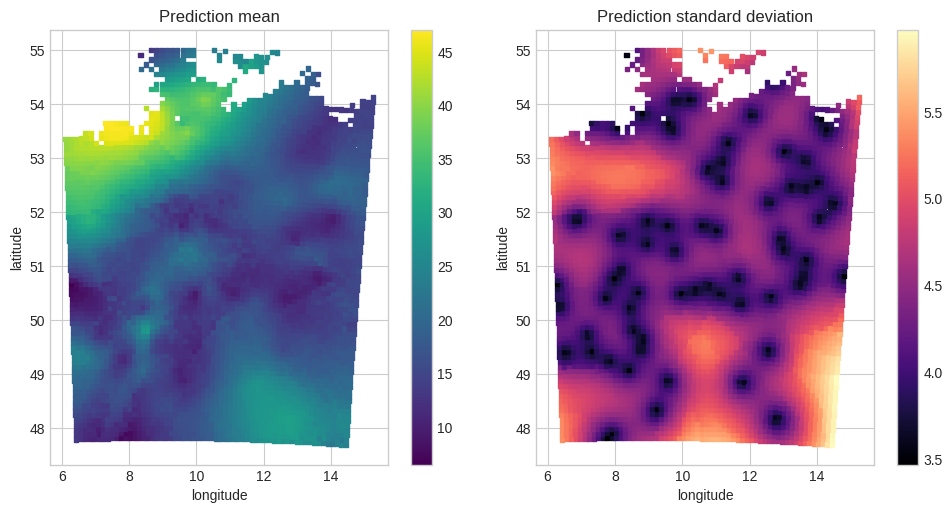

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
prediction_gdf.plot(column="prediction_mean", cmap="viridis", legend=True, ax=ax, markersize=9, marker="s")
ax.set_title("Prediction mean")
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

ax = axs[1]
prediction_gdf.plot(column="prediction_std", cmap="magma", legend=True, ax=ax, markersize=9, marker="s")
ax.set_title("Prediction standard deviation")
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
fig.tight_layout()
pass

As you can see, the predicted PM10 value is highest near the north sea. Not surprisingly, the uncertainty (std) is lowest near the measurement locations.

Now you have seen the basic functions of the STIF package. I hope it can be useful for you.